**Natural Language Processing (NLP)**

1. Bag of words
2. Latent Dirichlet Allocation(LDA) ([Tutorial Video](https://www.youtube.com/watch?v=BuMu-bdoVrU) watch 1st 1/2 of video))
3. RNN
4. LSTM

In [2]:
#Download IMDB dataset
import tensorflow as tf
#tf.enable_eager_execution()

import os
import sys
import tarfile
import time
import urllib.request

source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

urllib.request.urlretrieve(source, target)

('aclImdb_v1.tar.gz', <http.client.HTTPMessage at 0x7f4b4e3f16d8>)

In [0]:
import tarfile
with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
  tar.extractall()

In [4]:
!pip install pyprind
import pyprind
import pandas as pd
import os

# change the `basepath` to the directory of the
# unzipped movie dataset

basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:11


In [0]:
import numpy as np
#Shuffling the DataFrame:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [0]:
#Saving the assembled data as CSV file:
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

In [7]:
import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')
print("Shape: ", df.shape)
df.head(3)

Shape:  (50000, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


**Bag-of-words**

The bag-of-words model allows us to represent text
as numerical feature vectors. The idea behind bag-of-words is quite simple and can
be summarized as follows:
1. We create a vocabulary of unique tokens—for example for each word—from the
entire set of documents.
2. We construct a feature vector from each document that contains the counts
of how often each word occurs in the particular document.

In [0]:
#Vectorize
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
#By calling the fit_transform method on CountVectorizer, we just constructed the vocabulary 
# of the bag-of-words model and transformed the following three sentences into sparse feature vectors
bag = count.fit_transform(docs) 

In [9]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [10]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


In [0]:
#remove all of the HTML markup

import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

df['review'] = df['review'].apply(preprocessor)

In [0]:
#Word stemming: Find the root words

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [13]:
print(tokenizer('runners like running and thus they run'))
print(tokenizer_porter('runners like running and thus they run'))

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']
['runner', 'like', 'run', 'and', 'thu', 'they', 'run']


In [14]:
#stop-word removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot') if w not in stop]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['runner', 'like', 'run', 'run', 'lot']

In [0]:
# Here in class we are only using the first 2.5K for training and the last 2.5K for testing
# Please run at your own to divide the DataFrame of cleaned text documents into 25,000 documents for training
# and 25,000 documents for testing

X_train = df.loc[:2500, 'review'].values
y_train = df.loc[:2500, 'sentiment'].values
X_test = df.loc[47500 :, 'review'].values
y_test = df.loc[47500 :, 'sentiment'].values


In [16]:
# Use a GridSearchCV object to find the optimal set of parameters for our
# logistic regression model using 5-fold stratified cross-validation

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

#TFIDF, short for term frequency–inverse document frequency. Down weight the term frequency by relevance.
tfidf = TfidfVectorizer(strip_accents=None,   
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0, solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [17]:
#Print out the best parameter combination and the best cross validation scores
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each'

In [18]:
#Use the best estimators: We achieved about 90% accuracy
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.857


**LDA: Topic modeling with Latent Dirichlet Allocation**

Topic modeling describes the broad task of assigning topics to documents. Documents consists of words. Words have associated probability over given number of topic. Key input is number of topics. Unsurprised learning method.

Word -> Latent (Topics) -> Document 

The input to an LDA is the bag-of-words model that we discussed earlier
in this chapter. Given a bag-of-words matrix as input, LDA decomposes it into two
new matrices:

• A document-to-topic matrix

• A word-to-topic matrix

In [19]:
#Load dataset
import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')
df = df[:5000] #Please take out this constrant and run the whole database at home. It will take around 10 mints to run the model
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [0]:
# use the CountVectorizer to create the bag-ofwords
# matrix as input to the LDA
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english',
                        max_df=.1,   #we set the maximum document frequency of words to be considered to 10 percent (max_df=.1)
                                     # to exclude words that occur too frequently across documents.                        
                        max_features=5000)  #we limited the number of words to be considered 
                                            #to the most frequently occurring 5,000 words
X = count.fit_transform(df['review'].values)

In [0]:
# Fit a LatentDirichletAllocation
# estimator to the bag-of-words matrix and infer the 10 different topics from the
# documents(take 10 mints to run the whole dataset)

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                random_state=123)

X_topics = lda.fit_transform(X)

In [22]:
# To analyze the results, let's print the five most important words for each of the
# 10 topics. Note that the word importance values are ranked in increasing order.
# Thus, to print the top five words, we need to sort the topic array in reverse order

n_top_words = 5
feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
book read horror series different
Topic 2:
guy tv horror music girls
Topic 3:
death family believe day mother
Topic 4:
worst horror minutes effects budget
Topic 5:
series episode kids episodes car
Topic 6:
comedy jokes game laugh humor
Topic 7:
girl role goes wife woman
Topic 8:
war woman american mr women
Topic 9:
role performance family performances wonderful
Topic 10:
action series shot set shows


In [25]:
horror = X_topics[:, 5].argsort()[::-1]

for iter_idx, movie_idx in enumerate(horror[:3]):
    print('\nHorror #%d:' % (iter_idx + 1))
    print(df['review'][movie_idx][:300], '...')


Horror #1:
Stan Laurel and Oliver Hardy had extensive (separate) film careers before they were eventually teamed. For many of Ollie's pre-Stan films, he was billed on screen as Babe Hardy ... and throughout his adult life, Hardy was known to his friends as 'Babe'. While touring postwar Britain with Laurel in a ...

Horror #2:
I am listening to Istanbul, intent, my eyes closed: At first there is a gentle breeze And the leaves on the trees Softly sway; Out there, far away, The bells of water-carriers unceasingly ring; I am listening to Istanbul, intent, my eyes closed.<br /><br />I am listening to Istanbul, intent, my eyes ...

Horror #3:
Several years ago the Navy kept a studied distance away from the making of "Men of Honor," a film based on the experiences of the service's first black master chief diver's struggle to overcome virulent racism. Ever eager to support films showing our Navy's best side the U.S.S. Nimitz and two helico ...


**Recurrent neural networks (RNNs)**

Typical machine learning algorithms for supervised learning assume that the
input is independent and identically distributed (IID) data, which means that
the training examples are mutually independent and have the same underlying
distribution. In this regard, based on the mutual independence assumption, the
order in which the training examples are given to the model is irrelevant.

What makes sequences unique, compared to other types of data, is that elements
in a sequence appear in a certain order and are not independent of each other. For example: predicting stock prices

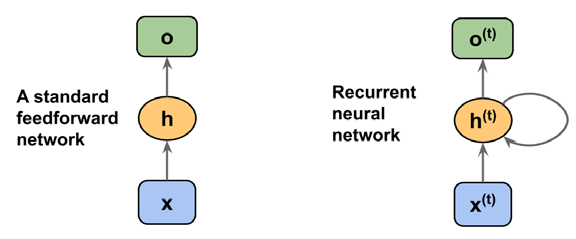

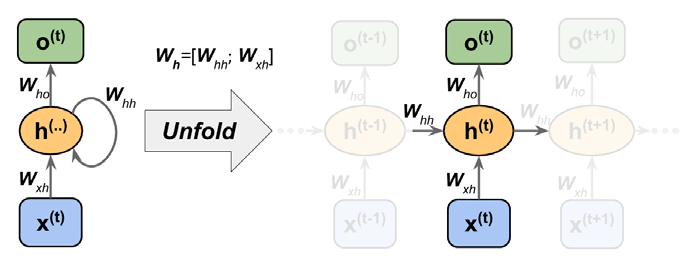

**Vanishing and exploding gradient problems**: The challenges of learning long-range interactions

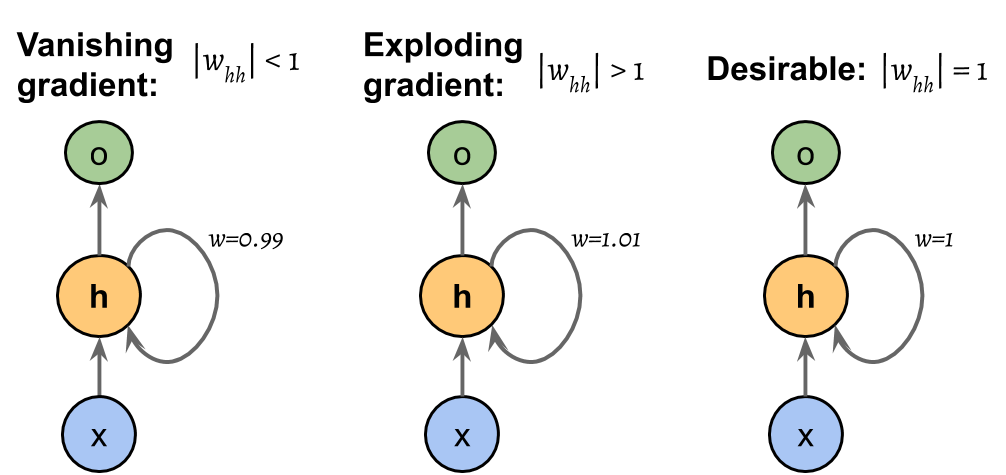

**Long short-term memory cells(LSTM)**

LSTM successfully solves the vanishing
and exploding gradient problems while modeling long-range dependencies through
the use of memory cells.

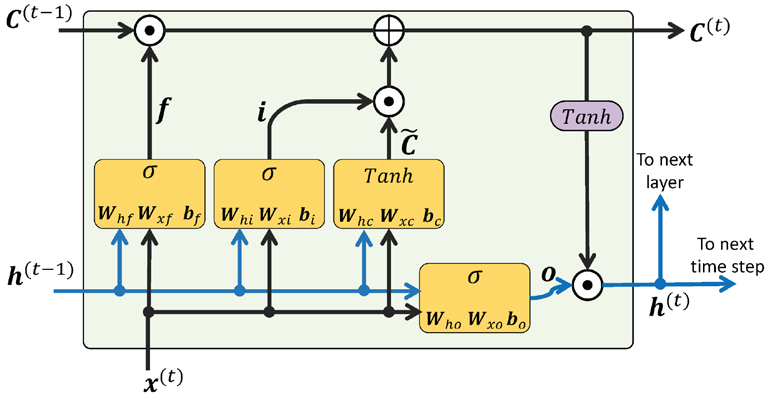

**1. Sentiment analysis using RNN: IMDb movie reviews**

Please note, below example is provided by Tensorflow team. For more details, please check:
https://colab.research.google.com/github/tensorflow/

In [0]:
import tensorflow as tf

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
import tensorflow as tf
# print(tf.__version__)

In [0]:
# If the tf.__version__ is 1.x, please run this cell
#!pip install tensorflow==2.0.0

<a id="download"></a>

## Download the IMDB dataset

The IMDB movie reviews dataset comes packaged in `tfds`. It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):

To encode your own text see the [Loading text tutorial](../load_data/text.ipynb)

In [28]:
# Get the data(Will take about 3 mints)
# Use the version pre-encoded with an ~8k vocabulary.  # Also return the `info` structure. 
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
# Return (example, label) pairs from the dataset (instead of a dictionary).
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteOHCGRM/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteOHCGRM/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteOHCGRM/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
# In class we are only going to use the first 2500 data. Please run the whole dataset on you own. There are 25000 for each training and testing in total
# train_dataset =train_dataset.take(2500) 
# test_dataset = test_dataset.take(2500)

<a id="encoder"></a>

## Try the encoder

 The dataset `info` includes the text encoder (a `tfds.features.text.SubwordTextEncoder`).

In [30]:
tokenizer = info.features['text'].encoder
print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string:

In [31]:
sample_string = 'Hello Johns Hopkins.'

encoded_string = tokenizer.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = tokenizer.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 5561, 8, 6274, 5814, 7975]
The original string: "Hello Johns Hopkins."


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [32]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

4025 ----> Hell
222 ----> o 
5561 ----> John
8 ----> s 
6274 ----> Hop
5814 ----> kins
7975 ----> .


## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. 

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary. 

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Here's what the first review looks like:

In [33]:
for train_example, train_label in train_dataset.take(1):
  print('Encoded text:', train_example.numpy())
  print('Label:', train_label.numpy())


Encoded text: [  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
Label: 0


The `info` structure contains the encoder/decoder. The encoder can be used to recover the original text:

In [34]:
tokenizer.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

## Prepare the data for training

You will want to create batches of training data for your model. The reviews are all different lengths, so use `padded_batch` to zero pad the sequences while batching:

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

Each batch will have a shape of `(batch_size, sequence_length)` because the padding is dynamic each batch will have a different length. The sequence_length for each batch is taken from longest text within that batch

In [36]:
for example_batch, label_batch in train_dataset.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)
  

Batch shape: (64, 1023)
label shape: (64,)
Batch shape: (64, 1217)
label shape: (64,)


## Build the model
The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          261920    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 268,737
Trainable params: 268,737
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

This is very important to know that in the below code, we arbitrarily pick "steps_per_epoch=8", which means every epoch we will only use 8*64(batch_size)=512 rows of data in order to run this for a reasonable time in class. Same for the "validation_step". When you run this on you own you should use the entire dataset.For example: setting steps to 25000/64=390


In [40]:
NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset, validation_steps=8,steps_per_epoch=8)  

Epoch 1/10
8/8 [==============================] - 9s 1s/step - loss: 0.6942 - accuracy: 0.4883 - val_loss: 0.6935 - val_accuracy: 0.4961
Epoch 2/10
8/8 [==============================] - 8s 994ms/step - loss: 0.6922 - accuracy: 0.5312 - val_loss: 0.6934 - val_accuracy: 0.4961
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 0.6925 - accuracy: 0.5059 - val_loss: 0.6933 - val_accuracy: 0.4961
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.6933 - accuracy: 0.4902 - val_loss: 0.6929 - val_accuracy: 0.4941
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.6923 - accuracy: 0.5254 - val_loss: 0.6926 - val_accuracy: 0.4961
Epoch 6/10
8/8 [==============================] - 13s 2s/step - loss: 0.6930 - accuracy: 0.4863 - val_loss: 0.6924 - val_accuracy: 0.5332
Epoch 7/10
8/8 [==============================] - 11s 1s/step - loss: 0.6918 - accuracy: 0.5449 - val_loss: 0.6923 - val_accuracy: 0.5430
Epoch 8/10
8/8 [====================

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

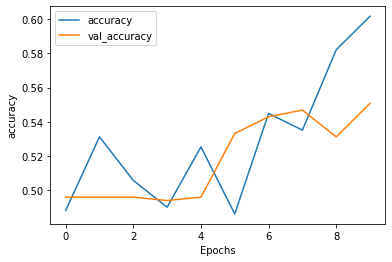

In [45]:
plot_graphs(history, 'accuracy')

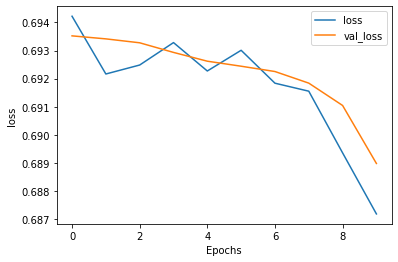

In [46]:
plot_graphs(history, 'loss')

**2. Text generation with an RNN**

Please note, below example is provided by laurence moroney. For more details, please check:
https://github.com/lmoroney

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

Below link is a txt dataset of Shakespeare's writing. We are going to ML how to write like Shakespeare!

In [0]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
# example:[[I, am], [I, am, Joe], [I, am, Joe, Zhou]] -> [[1,2],[1,2,85],[1,2,85,5]]
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
# example:[[1,2],[1,2,85],[1,2,85,5]] ->[[0,0,1,2],[0,1,2,85],[1,2,85,5]]
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))#"pre means put 0 at the front instead of at the end"

# create predictors and label
# example: [1,2,85,5]:[1,2,85],[5]

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [0]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
print(model.summary())


In [0]:
 history = model.fit(predictors, label, epochs=15, verbose=1)

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [0]:
seed_text = "Professor Liew is the best professor in Johns Hopkins, and I should be the king of the world if I master this course"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

## Assignment 6
1. Rerun first part but use all the data in IMDB. 

Please run at your own to divide the DataFrame of cleaned text documents into 25,000 documents for training and 25,000 documents for testing

Change below:

X_train = df.loc[:2500, 'review'].values

y_train = df.loc[:2500, 'sentiment'].values

X_test = df.loc[47500 :, 'review'].values

y_test = df.loc[47500 :, 'sentiment'].values



## Assignment 6 (optional)

Use the 2015-2019.txt file, which contains the Buffett's 2015-2019 annual letters to shareholders, and build a LSTM model.

1. Your model should have a embedding layer, one LSTM layers with 150 neurons.
2. Please include Dropout or L2 regularization
3. Plot the training accuracy and loss 
4. Use your model to predict the next 50 words starts from:"This is my favorate stock, and it is a great company. In 2020 We should invest in". Try to make it sounds like meaningful sentences.

Extra credit: 
Build a scale_factor function to control the randomness of the predicted word. Show two comparing examples using the same starting word above:"This is my favorate stock, and it is a great company. In 2020 We should invest in". 